## Introduction

Nous souhaitons créer un modèle de détection de races de chiens sur une photo. Nous utiliserons pour cela deux approches:  
- La première en créant notre propre réseau de neurones convolutionnel
- La deuxième en utilisant un CNN pré-entraîné (transfer learning).

Par souci de capacité de mémoire, nous nous limiterons à la détection des 20 races contenant le plus de photos dans jeu de données.  

Nous exporterons le modèle sélectionné sous la forme "my_model.h5" et la fonction du programme "prediction_breed.py" prendra en entrée une photo de chien et prédira la race la plus probable retournée par le modèle.

## I. Configuration de l'environnement de travail  

Cette partie a pour objectif de définir notre environnement de travail : Simplifier les noms des dossiers pour chacune des races de chiens, déterminer et sélectionner les 20 races ayant le plus de photos, ainsi que de crééer des dossiers contenant les jeux d'entrainement et de test de nos futurs modèles.

In [ ]:
#!pip install split-folders

In [ ]:
#Import useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imshow 
from skimage.transform import resize
import seaborn as sns
import random
import os
import sys
import shutil
#import splitfolders
import time

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import regularizers, Input, Model, optimizers
from tensorflow.keras.applications import vgg16, resnet50

In [ ]:
# Path of data base pictures organized by breed name.
images_path = "/content/drive/MyDrive/projet6/data/Images"

#Path for 20 breed names with most pictures
main_images_path = '/content/drive/MyDrive/projet6/data/mainImages'

#Path for test set
path_test = '/content/drive/MyDrive/projet6/data/test'

#Path for train set
path_train = '/content/drive/MyDrive/projet6/data/train'

#Sizes
width = 224
height = 224

D'abord renommons les dossiers contenant chacune des races de chien. 

---



In [ ]:
classes = os.listdir(images_path)

In [ ]:
#classes[:20]

In [ ]:
import re
def clean_names(text):
  '''cleans folders'name'''
  text = re.sub(r'n\d+\-','',text)
  text = re.sub(r'-','_',text)
  text = text.lower()
  return text

In [ ]:
clean_names('n02111500-Great_Pyrenees')

'great_pyrenees'

In [ ]:
#rename folders and keep classe's names in breeds_list
breeds_list= []
for f in classes:
  newname = clean_names(f)
  os.rename(images_path + '/' + f, images_path + '/' + newname)
  breeds_list.append(newname)

In [ ]:
breeds_list[:5]

['miniature_poodle', 'dhole', 'mexican_hairless', 'dingo', 'cardigan']

In [ ]:
len(breeds_list)

120

120 races sont présentes. Etudions la distribution.

In [ ]:
# List of path folder for each breed
path_classes = [images_path + '/' + c for c in breeds_list]

#Corresponding number of images for each breed
n = [len(os.listdir(f)) for f in path_classes]

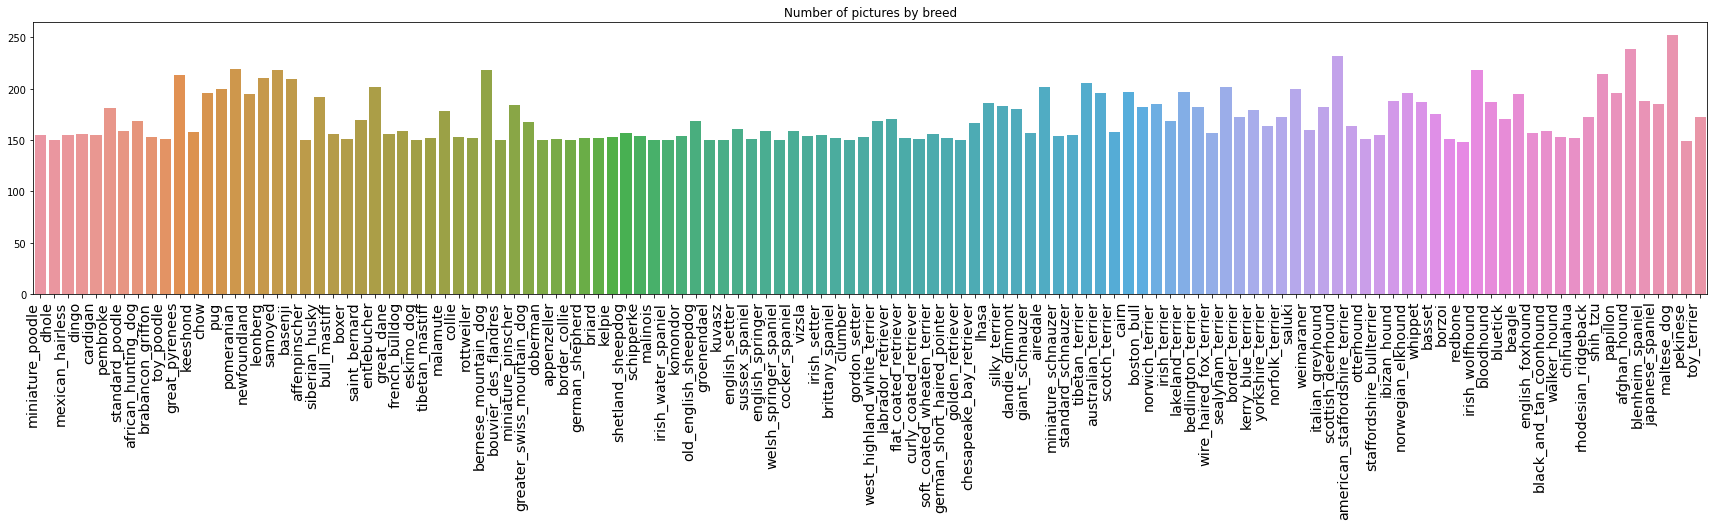

In [ ]:
#Bar plot for breeds distribution
plt.figure(figsize=(30,5))
sns.barplot(y=n,x=breeds_list)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.title('Number of pictures by breed')
plt.show()

Nous avons au moins 150 images par race. Affichons en quelques unes:


In [ ]:
def plot_images(breed_name):
  '''plot randomly five images given a breed name'''
  fig = plt.figure(figsize=(12,12))
  fig.patch.set_facecolor('#343434')
  plt.suptitle(breed_name, y=.83,color="white", fontsize=22)
  images = random.sample(os.listdir(images_path + "/" + breed_name),5)

  for i in range(5):
        img = imread(images_path+"/"+breed_name+"/"+images[i])
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
  plt.show()

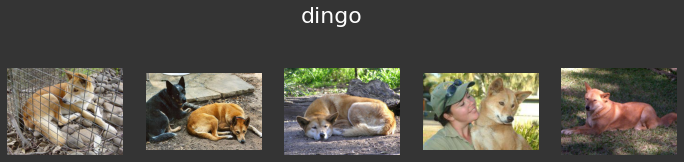

In [ ]:
plot_images('dingo')

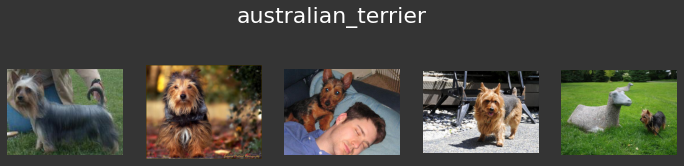

In [ ]:
plot_images('australian_terrier')

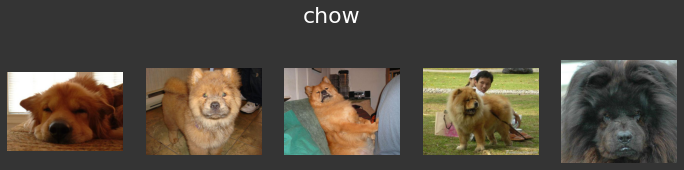

In [ ]:
plot_images('chow')

Nous pouvons bien observer une diversité dans les définitions d'images, les plans, les angles, la luminosité.

Nous allons travailler avec les 20 races les plus présentes.

In [ ]:
# Define the number of most present breeds
nbreeds = 20

In [ ]:
#Put main breeds in dataframe
d = {'breed': breeds_list, 'n':n ,'path': path_classes}
dg = pd.DataFrame(data=d)
dg = dg.sort_values('n',ascending=False)[:nbreeds].reset_index(drop=True)

In [ ]:
dg

,breed,n,path
0,maltese_dog,252,/content/drive/MyDrive/projet6/data/Images/mal...
1,afghan_hound,239,/content/drive/MyDrive/projet6/data/Images/afg...
2,scottish_deerhound,232,/content/drive/MyDrive/projet6/data/Images/sco...
3,pomeranian,219,/content/drive/MyDrive/projet6/data/Images/pom...
4,bernese_mountain_dog,218,/content/drive/MyDrive/projet6/data/Images/ber...
5,samoyed,218,/content/drive/MyDrive/projet6/data/Images/sam...
6,irish_wolfhound,218,/content/drive/MyDrive/projet6/data/Images/iri...
7,shih_tzu,214,/content/drive/MyDrive/projet6/data/Images/shi...
8,great_pyrenees,213,/content/drive/MyDrive/projet6/data/Images/gre...
9,leonberg,210,/content/drive/MyDrive/projet6/data/Images/leo...


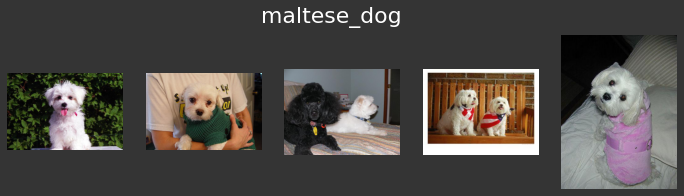

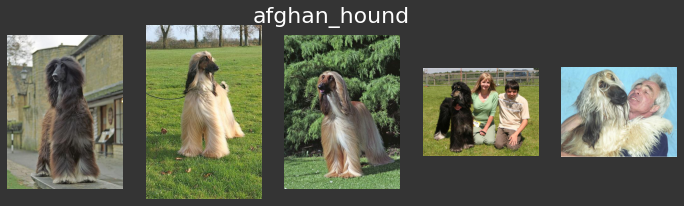

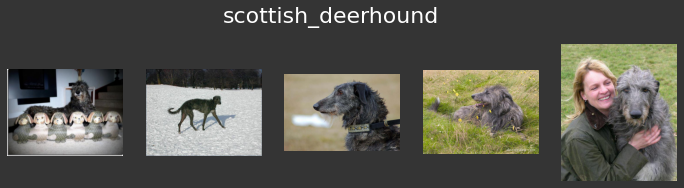

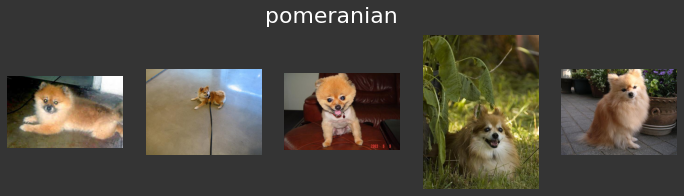

In [ ]:
#Plot Most present breeds
for i in range(4):
  plot_images(dg.iloc[i,0])

In [ ]:
#Define main images in a list
main_breeds_list = dg.breed.tolist()

In [ ]:
main_breeds_list

['maltese_dog',
 'afghan_hound',
 'scottish_deerhound',
 'pomeranian',
 'bernese_mountain_dog',
 'samoyed',
 'irish_wolfhound',
 'shih_tzu',
 'great_pyrenees',
 'leonberg',
 'basenji',
 'tibetan_terrier',
 'airedale',
 'sealyham_terrier',
 'entlebucher',
 'pug',
 'saluki',
 'cairn',
 'lakeland_terrier',
 'papillon']

In [ ]:
#Create folder containing only main breeds. We call it mainImages
#os.mkdir(main_images_path)

In [ ]:
t1 = time.time()

#for breed in main_breeds_list:
  #copy folder from Images into mainImages folder
  #os.mkdir(main_images_path + '/' + breed)
  #shutil.copytree(images_path + '/' + breed,
                  #main_images_path + '/' + breed) 

t2 = time.time()

print('Time to create folders : {} s'.format(t2-t1))


Time to create folders : 1.6689300537109375e-05 s


In [ ]:
#Create train and test folders (We won't use validation set)
#splitfolders.ratio(input=main_images_path,
#                   output="/content/drive/MyDrive/projet6/data",
 #                  seed=1337, 
 #                  ratio=(.8, .0, .2),
 #                  group_prefix=None)

On vérifie les distributions dans les jeux de train et de test.

In [ ]:
classes_test = [path_test + '/' + b for b in main_breeds_list]
#Corresponding number of images for each breed
n = [len(os.listdir(f)) for f in classes_test]

print(len(classes))

120


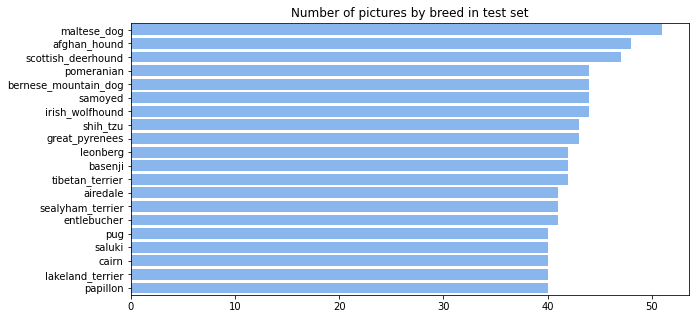

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=n,y=main_breeds_list, color='#77b5fe')

plt.title('Number of pictures by breed in test set')
plt.show()

20


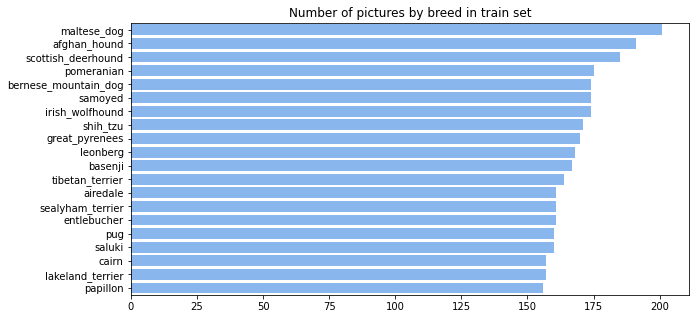

In [ ]:
#Distribution in train set
classes_train = [path_train + '/' + b for b in main_breeds_list]
#Corresponding number of images for each breed
n = [len(os.listdir(f)) for f in classes_train]
print(len(classes_train))
plt.figure(figsize=(10,5))
sns.barplot(x=n,y=main_breeds_list, color='#77b5fe')

plt.title('Number of pictures by breed in train set')
plt.show()

Les distributions dans les jeu de train et train qont quasiment identiques.

On stocke nos jeux d'entrainement et de test dans les variables X_train et X_test, avec leurs étiquettes correspondantes y_train, y_test, en changeant leur taille.  

D'abord illustrons un petit exemple de re-définition d'image:

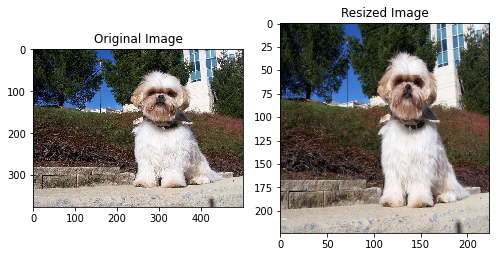

In [ ]:
#Resize image example
example_path = '/content/drive/MyDrive/projet6/data/mainImages/shih_tzu/n02086240_1011.jpg'
img = imread(example_path)

#resize image
width = 224
height = 224
img_resized = resize(img, (width, height, 3))

#plot images
fig = plt.figure(figsize=(7,7))
plt.subplot(121), imshow(img)
plt.title('Original Image')
plt.subplot(122), imshow(img_resized)
plt.title('Resized Image')
plt.show()


In [ ]:
print(img.shape)
print(img_resized.shape)

(375, 500, 3)
(224, 224, 3)


In [ ]:
width = 224
height = 224

def define_arrays(path, w=width, h=height):
  ''' Defines np arrays of images X and labels y given a path folder (train or test).
  Images are resized'''
  X = []
  y = []
  for folder in os.listdir(path):

    for image_name in os.listdir(path +'/' + folder):

      img = imread(path + '/' + folder + '/'+ image_name )
      img_resized = resize(img, (w, h, 3))
      X.append(img_resized)
      y.append(folder)

  #rescale images and transform X and y into numpy arrays
  X = np.array(X, dtype="float")
  y = np.array(y)

  #shuffle -> useless because provided by  keras fit method
  #n = np.arange(X.shape[0])
  #np.random.shuffle(n)
  #X = X[n]
  #y = y[n]
  # Reshape y
  y.shape = (X.shape[0], 1)
  return X, y


In [ ]:
X_train, y_train = define_arrays(path_train)

In [ ]:
X_test, y_test = define_arrays(path_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(3387, 224, 224, 3)
(3387, 1)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(857, 224, 224, 3)
(857, 1)


In [ ]:
y_test[:5]

array([['maltese_dog'],
       ['maltese_dog'],
       ['maltese_dog'],
       ['maltese_dog'],
       ['maltese_dog']], dtype='<U20')

In [ ]:
#encode labels
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
encoder.classes_

array(['afghan_hound', 'airedale', 'basenji', 'bernese_mountain_dog',
       'cairn', 'entlebucher', 'great_pyrenees', 'irish_wolfhound',
       'lakeland_terrier', 'leonberg', 'maltese_dog', 'papillon',
       'pomeranian', 'pug', 'saluki', 'samoyed', 'scottish_deerhound',
       'sealyham_terrier', 'shih_tzu', 'tibetan_terrier'], dtype='<U20')

In [ ]:
y_test[:5]

array([10, 10, 10, 10, 10])

On définit une fonction qui permettra de visualiser les performances de nos modèles.

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

##  II. Un premier réseau de convolution

### Création du CNN
On s'inspire sur réseau de convolution VGG16.

In [ ]:
print(width, height)

224 224


In [ ]:
my_VGG16 = Sequential()
my_VGG16.add(Conv2D(64, (3, 3), input_shape=(width, height, 3), padding='same', activation='relu'))
my_VGG16.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16.add(Flatten()) 
my_VGG16.add(Dense(256, activation='relu'))
my_VGG16.add(Dense(nbreeds, activation='softmax')) 

my_VGG16.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [ ]:
t1= time.time()
my_VGG16.fit(X_train, to_categorical(y_train), epochs=10, batch_size = 32, shuffle=True)
t2 = time.time()

Epoch 1/10
106/106 [==============================] - 21s 100ms/step - loss: 5.5069 - accuracy: 0.0570
Epoch 2/10
106/106 [==============================] - 10s 91ms/step - loss: 2.9431 - accuracy: 0.1030
Epoch 3/10
106/106 [==============================] - 10s 92ms/step - loss: 2.1306 - accuracy: 0.4009
Epoch 4/10
106/106 [==============================] - 10s 97ms/step - loss: 0.6218 - accuracy: 0.8385
Epoch 5/10
106/106 [==============================] - 10s 92ms/step - loss: 0.1024 - accuracy: 0.9802
Epoch 6/10
106/106 [==============================] - 10s 91ms/step - loss: 0.0789 - accuracy: 0.9938
Epoch 7/10
106/106 [==============================] - 10s 96ms/step - loss: 0.0296 - accuracy: 0.9979
Epoch 8/10
106/106 [==============================] - 11s 102ms/step - loss: 0.0433 - accuracy: 0.9988
Epoch 9/10
106/106 [==============================] - 10s 95ms/step - loss: 0.0282 - accuracy: 0.9991
Epoch 10/10
106/106 [==============================] - 10s 91ms/step - loss: 0.0

In [ ]:
print('time: {} s'.format(t2-t1))

time: 147.52341222763062 s


In [ ]:
my_VGG16.evaluate(X_test, to_categorical(y_test))

27/27 [==============================] - 2s 47ms/step - loss: 6.4583 - accuracy: 0.1167


[6.458297252655029, 0.11668611317873001]

Nous constatons que nous sommes en overfitting. Nous ajoutons une couche dropout, des regularizers afin de limiter l'amplitude des poids et nous diminuons le nombre d'unités de sorties de l'avant dernière couche. 

### Amélioration afin de limiter l'overfitting

Afin d'essayer de remédier à l'overfitiing, nous ajoutons une couche dropout, des regularizers afin de limiter l'amplitude des poids et nous diminuons le nombre d'unités de sorties de l'avant dernière couche.  
Nous réalisons plusieurs essais sur la position de la couche Dropout et la valeur du paramètre du regularizer.

In [ ]:
#Add Dropout layer after FC1
my_VGG16 = Sequential()
my_VGG16.add(Conv2D(64, (3, 3), input_shape=(width, height, 3), padding='same', activation='relu'))
my_VGG16.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16.add(Flatten()) 

#my_VGG16.add(Dropout(0.5))
my_VGG16.add(Dense(64, activation='relu')) 
my_VGG16.add(Dropout(0.5))
my_VGG16.add(Dense(nbreeds, activation='softmax')) 

my_VGG16.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [ ]:
t1 = time.time()
my_VGG16.fit(X_train, to_categorical(y_train), epochs=10, batch_size = 32, shuffle=True)
t2 = time.time()

Epoch 1/10
106/106 [==============================] - 19s 87ms/step - loss: 4.1831 - accuracy: 0.0593
Epoch 2/10
106/106 [==============================] - 8s 79ms/step - loss: 2.9668 - accuracy: 0.0877
Epoch 3/10
106/106 [==============================] - 8s 79ms/step - loss: 2.9167 - accuracy: 0.0992
Epoch 4/10
106/106 [==============================] - 8s 79ms/step - loss: 2.7912 - accuracy: 0.1538
Epoch 5/10
106/106 [==============================] - 8s 79ms/step - loss: 2.4284 - accuracy: 0.2539
Epoch 6/10
106/106 [==============================] - 8s 79ms/step - loss: 1.9710 - accuracy: 0.3912
Epoch 7/10
106/106 [==============================] - 8s 79ms/step - loss: 1.5759 - accuracy: 0.5001
Epoch 8/10
106/106 [==============================] - 8s 79ms/step - loss: 1.2968 - accuracy: 0.5867
Epoch 9/10
106/106 [==============================] - 8s 79ms/step - loss: 1.1360 - accuracy: 0.6351
Epoch 10/10
106/106 [==============================] - 8s 79ms/step - loss: 0.9769 - accur

In [ ]:
print('Time : {} s'.format(t2-t1))

Time : 97.8155620098114 s


In [ ]:
my_VGG16.evaluate(X_test, to_categorical(y_test))

27/27 [==============================] - 1s 47ms/step - loss: 4.3312 - accuracy: 0.1097


[4.331157684326172, 0.10968494415283203]

In [ ]:
#Add L2 regularizer param 0.001
my_VGG16 = Sequential()
my_VGG16.add(Conv2D(64, (3, 3), input_shape=(width, height, 3), padding='same', activation='relu'))
my_VGG16.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16.add(Flatten()) 


my_VGG16.add(Dropout(0.5))
my_VGG16.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))) 
my_VGG16.add(Dense(nbreeds, activation='softmax')) 

my_VGG16.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

t1 = time.time()
my_VGG16.fit(X_train, to_categorical(y_train), epochs=10, batch_size = 32, shuffle=True)
t2 = time.time()
print('Time : {} s'.format(t2-t1))

my_VGG16.evaluate(X_test, to_categorical(y_test))

Epoch 1/10
106/106 [==============================] - 21s 97ms/step - loss: 4.3038 - accuracy: 0.0496
Epoch 2/10
106/106 [==============================] - 9s 83ms/step - loss: 3.2335 - accuracy: 0.0564
Epoch 3/10
106/106 [==============================] - 9s 82ms/step - loss: 3.1293 - accuracy: 0.0543
Epoch 4/10
106/106 [==============================] - 9s 83ms/step - loss: 3.0805 - accuracy: 0.0555
Epoch 5/10
106/106 [==============================] - 9s 83ms/step - loss: 3.0796 - accuracy: 0.0800
Epoch 6/10
106/106 [==============================] - 9s 82ms/step - loss: 3.0113 - accuracy: 0.1063
Epoch 7/10
106/106 [==============================] - 9s 83ms/step - loss: 2.9558 - accuracy: 0.1349
Epoch 8/10
106/106 [==============================] - 9s 85ms/step - loss: 2.8406 - accuracy: 0.1804
Epoch 9/10
106/106 [==============================] - 9s 83ms/step - loss: 2.6420 - accuracy: 0.2513
Epoch 10/10
106/106 [==============================] - 9s 82ms/step - loss: 2.4313 - accur

[3.569432020187378, 0.0968494713306427]

In [ ]:
#Add l2 regularizer parma 1e-5
my_VGG16 = Sequential()
my_VGG16.add(Conv2D(64, (3, 3), input_shape=(width, height, 3), padding='same', activation='relu'))
my_VGG16.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16.add(Flatten()) 


my_VGG16.add(Dropout(0.5))
my_VGG16.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.00001))) 
my_VGG16.add(Dense(nbreeds, activation='softmax')) 

my_VGG16.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

t1 = time.time()
my_VGG16.fit(X_train, to_categorical(y_train), epochs=10, batch_size = 32, shuffle=True)
t2 = time.time()

print('Time : {} s'.format(t2-t1))

my_VGG16.evaluate(X_test, to_categorical(y_test))

Epoch 1/10
106/106 [==============================] - 19s 91ms/step - loss: 4.0646 - accuracy: 0.0605
Epoch 2/10
106/106 [==============================] - 9s 83ms/step - loss: 2.9174 - accuracy: 0.1027
Epoch 3/10
106/106 [==============================] - 9s 83ms/step - loss: 2.7767 - accuracy: 0.1662
Epoch 4/10
106/106 [==============================] - 9s 83ms/step - loss: 2.5454 - accuracy: 0.2347
Epoch 5/10
106/106 [==============================] - 9s 85ms/step - loss: 2.0284 - accuracy: 0.4045
Epoch 6/10
106/106 [==============================] - 9s 82ms/step - loss: 1.2855 - accuracy: 0.6159
Epoch 7/10
106/106 [==============================] - 9s 83ms/step - loss: 0.7070 - accuracy: 0.7995
Epoch 8/10
106/106 [==============================] - 9s 83ms/step - loss: 0.3913 - accuracy: 0.8970
Epoch 9/10
106/106 [==============================] - 9s 83ms/step - loss: 0.2429 - accuracy: 0.9398
Epoch 10/10
106/106 [==============================] - 9s 83ms/step - loss: 0.1959 - accur

[6.822941303253174, 0.13768962025642395]

Best trial:

In [ ]:
my_VGG16 = Sequential()
my_VGG16.add(Conv2D(64, (3, 3), input_shape=(width, height, 3), padding='same', activation='relu'))
my_VGG16.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16.add(Flatten()) 

#Ajout d'une couche Dropout
my_VGG16.add(Dropout(0.5))
my_VGG16.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))) 
my_VGG16.add(Dense(nbreeds, activation='softmax')) 

my_VGG16.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [ ]:
t1 = time.time()
my_VGG16.fit(X_train, to_categorical(y_train), epochs=10, batch_size = 32, shuffle=True)
t2 = time.time()

Epoch 1/10
106/106 [==============================] - 20s 91ms/step - loss: 4.0735 - accuracy: 0.0644
Epoch 2/10
106/106 [==============================] - 9s 83ms/step - loss: 3.0041 - accuracy: 0.1110
Epoch 3/10
106/106 [==============================] - 9s 85ms/step - loss: 2.4909 - accuracy: 0.3153
Epoch 4/10
106/106 [==============================] - 9s 85ms/step - loss: 1.3110 - accuracy: 0.6823
Epoch 5/10
106/106 [==============================] - 9s 83ms/step - loss: 0.6210 - accuracy: 0.9153
Epoch 6/10
106/106 [==============================] - 9s 83ms/step - loss: 0.4257 - accuracy: 0.9720
Epoch 7/10
106/106 [==============================] - 9s 86ms/step - loss: 0.3926 - accuracy: 0.9826
Epoch 8/10
106/106 [==============================] - 9s 83ms/step - loss: 0.3526 - accuracy: 0.9920
Epoch 9/10
106/106 [==============================] - 9s 83ms/step - loss: 0.3595 - accuracy: 0.9900
Epoch 10/10
106/106 [==============================] - 9s 84ms/step - loss: 0.4289 - accur

In [ ]:
print('Time : {} s'.format(t2-t1))

Time : 105.04740619659424 s


In [ ]:
my_VGG16.evaluate(X_test, to_categorical(y_test))

27/27 [==============================] - 2s 48ms/step - loss: 7.7096 - accuracy: 0.1459


[7.7096171379089355, 0.14585764706134796]

L'accuracy sur le jeu de test est un peu meilleure. Pour améliorer notre modèle on utilise la data augmentation. 

## III. Data Augmentation et amélioration du CNN from scratch.

### 1. Principe de la data augmentation

Le principe de la data augmentation est de générer de nouvelles images à partir de celles existantes en appliquant des modifications. Les plus communes sont:  
- le "shifting" : décaler l'image horizontalement ou verticalement
- le "flippling" : créer une image symétrique
- la rotation 
- la modification de la luminosité
- le zoom

On illustre ci-dessous la data augmentation d'une image. 

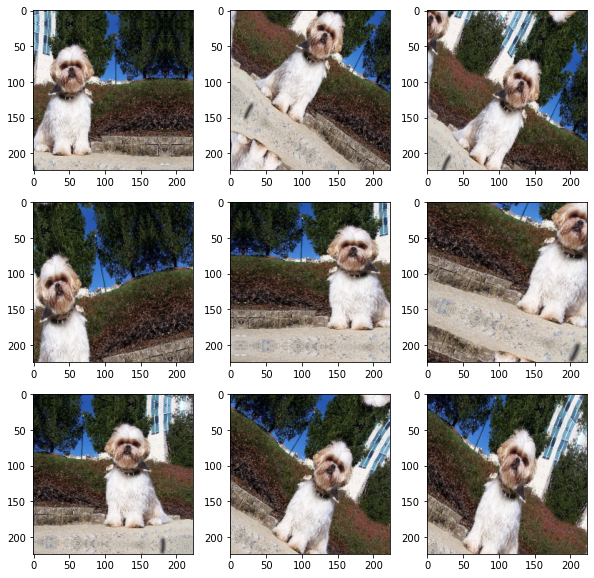

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect')

img = load_img(example_path, target_size=(width, height))  
x = img_to_array(img)
x = x.reshape((1,) + x.shape) 

# prepare iterator
it = datagen.flow(x, batch_size=1)

# generate samples and plot
plt.figure(figsize=(10,10))
for i in range(9): 
  ax = plt.subplot(3,3,i+1)
  batch = it.next()
  image = batch[0].astype('uint8')
  plt.imshow(image)

plt.show()

### 2. CNN avec data augmentation

On réalise data-augmentation, en appliquant en plus dans le pre-processing le *zca-whitening* qui est une technique de réduction de dimension pour les images. Cette technique se base sur le fait que des pixels adjacents ont des valeurs redondantes. (cf http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/)   
On recentre également les valeurs des pixels entre -1 et 1.

In [ ]:
#Define transformations fo Data Augmentation
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode="reflect",
        zca_whitening=True)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
#Only rescaling test set 
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
# this is a generator that will read pictures found in
# subfolers, and indefinitely generate batches of augmented image data

train_generator = train_datagen.flow_from_directory(
                                                    path_train, 
                                                    target_size=(width, height),  
                                                    color_mode = "rgb",
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    classes = main_breeds_list
                                                    )  

test_generator = test_datagen.flow_from_directory(
                                                  path_test,
                                                  target_size=(width, height),  
                                                  color_mode = "rgb",
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  classes = main_breeds_list
                                                  )


Found 3387 images belonging to 20 classes.
Found 857 images belonging to 20 classes.


In [ ]:
#Define CNN
my_VGG16 = Sequential()
my_VGG16.add(Conv2D(64, (3, 3), input_shape=(width, height, 3), padding='same', activation='relu'))
my_VGG16.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16.add(Flatten()) 

#Ajout d'une couche Dropout
my_VGG16.add(Dropout(0.5))
my_VGG16.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))) 
my_VGG16.add(Dense(nbreeds, activation='softmax')) 

my_VGG16.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [ ]:
t1 = time.time()
history = my_VGG16.fit_generator(train_generator,
                                 steps_per_epoch=3387 // 32,
                                 epochs=100,
                                 validation_data=test_generator,
                                 validation_steps=857 // 32)
t2 = time.time()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
105/105 [==============================] - 65s 607ms/step - loss: 3.7439 - accuracy: 0.0492 - val_loss: 3.0751 - val_accuracy: 0.0721
Epoch 2/100
105/105 [==============================] - 63s 605ms/step - loss: 3.0633 - accuracy: 0.0602 - val_loss: 3.0541 - val_accuracy: 0.0565
Epoch 3/100
105/105 [==============================] - 63s 602ms/step - loss: 3.0429 - accuracy: 0.0662 - val_loss: 3.0346 - val_accuracy: 0.0685
Epoch 4/100
105/105 [==============================] - 63s 602ms/step - loss: 3.0394 - accuracy: 0.0596 - val_loss: 3.0394 - val_accuracy: 0.0589
Epoch 5/100
105/105 [==============================] - 63s 603ms/step - loss: 3.0346 - accuracy: 0.0569 - val_loss: 3.0267 - val_accuracy: 0.0625
Epoch 6/100
105/105 [==============================] - 63s 602ms/step - loss: 3.0116 - accuracy: 0.0665 - val_loss: 3.0066 - val_accuracy: 0.0781
Epoch 7/100
105/105 [==============================] - 63s 604ms/step - loss: 2.9981 - accuracy: 0.0793 - val_loss: 2.9542 -

In [ ]:
print('time : {} min'.format(np.round((t2-t1)/60))) 

time : 121.0 min


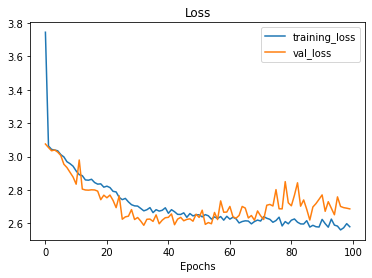

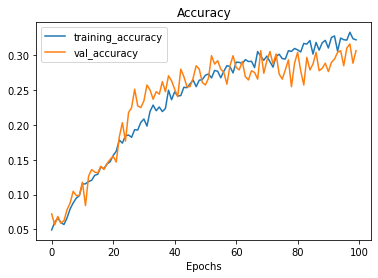

In [ ]:
plot_loss_curves(history)

### Ajout de deux couches
Nous avons enlevé l'overfitting. Essayons maintenant d'améliorer la performance globale : Toujours en s'inspirant du réseau de neurones VGG16, on ajoute deux couches de convolution (chacune avec 128 filtres de taille (3,3)) et une couche de max pooling.


In [ ]:
#Define transformations
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode="reflect",
        zca_whitening=True)

#Only rescaling test set 
test_datagen = ImageDataGenerator(rescale=1/255.0)

# this is a generator that will read pictures found in
# subfolers, and indefinitely generate batches of augmented image data

train_generator = train_datagen.flow_from_directory(
                                                    path_train, 
                                                    target_size=(width, height),  
                                                    color_mode = "rgb",
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    classes = main_breeds_list
                                                    )  

test_generator = test_datagen.flow_from_directory(
                                                  path_test,
                                                  target_size=(width, height),  
                                                  color_mode = "rgb",
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  classes = main_breeds_list
                                                  )


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 3387 images belonging to 20 classes.
Found 857 images belonging to 20 classes.


In [ ]:
#Define CNN
my_VGG16 = Sequential()
my_VGG16.add(Conv2D(64, (3, 3), input_shape=(width, height, 3), padding='same', activation='relu'))
my_VGG16.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

my_VGG16.add(Conv2D(128, (3, 3), input_shape=(width, height, 3), padding='same', activation='relu'))
my_VGG16.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

my_VGG16.add(Flatten()) 

#Ajout d'une couche Dropout
my_VGG16.add(Dropout(0.5))
my_VGG16.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))) 
my_VGG16.add(Dense(nbreeds, activation='softmax')) 

my_VGG16.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [ ]:
t1 = time.time()
history = my_VGG16.fit_generator(train_generator,
                                 steps_per_epoch=3387 // 32,
                                 epochs=100,
                                 validation_data=test_generator,
                                 validation_steps=857 // 32)
t2 = time.time()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
105/105 [==============================] - 68s 587ms/step - loss: 3.1564 - accuracy: 0.0507 - val_loss: 3.0315 - val_accuracy: 0.0565
Epoch 2/100
105/105 [==============================] - 62s 592ms/step - loss: 3.0249 - accuracy: 0.0617 - val_loss: 3.0140 - val_accuracy: 0.0685
Epoch 3/100
105/105 [==============================] - 66s 623ms/step - loss: 3.0020 - accuracy: 0.0787 - val_loss: 2.9609 - val_accuracy: 0.0913
Epoch 4/100
105/105 [==============================] - 60s 571ms/step - loss: 2.9666 - accuracy: 0.0861 - val_loss: 2.9070 - val_accuracy: 0.1022
Epoch 5/100
105/105 [==============================] - 58s 546ms/step - loss: 2.9416 - accuracy: 0.0939 - val_loss: 2.8772 - val_accuracy: 0.0998
Epoch 6/100
105/105 [==============================] - 58s 549ms/step - loss: 2.9103 - accuracy: 0.0951 - val_loss: 2.8329 - val_accuracy: 0.1346
Epoch 7/100
105/105 [==============================] - 58s 547ms/step - loss: 2.8844 - accuracy: 0.1046 - val_loss: 2.7820 -

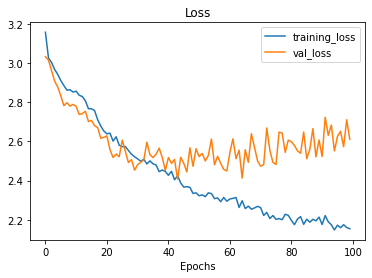

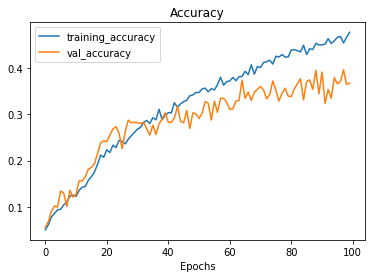

In [ ]:
plot_loss_curves(history)

## IV. Transfer learning

### VGG16

On utilise le réseau de neurones pré-entraîné VGG16

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

In [ ]:
train_data_generator = train_datagen.flow_from_directory(
                                                          path_train,
                                                          target_size=(width, height),
                                                          classes = main_breeds_list,
                                                          batch_size =32,
                                                          class_mode='categorical'
                                                          )
test_data_generator = test_datagen.flow_from_directory(
                                                        path_test,
                                                        target_size=(width, height),
                                                        classes=main_breeds_list,
                                                        batch_size=32,
                                                        class_mode='categorical'
                                                       )


Found 3387 images belonging to 20 classes.
Found 857 images belonging to 20 classes.


In [ ]:
vgg16 = vgg16.VGG16(include_top=False, weights='imagenet')
#we only train classifier
vgg16.trainable=False

In [ ]:
inputs = Input(shape=(width,height,3))

In [ ]:
x = vgg16(inputs)
x = GlobalAveragePooling2D()(x)

In [ ]:
outputs = Dense(nbreeds, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
t1 = time.time()
history = model.fit(train_data_generator, 
                    validation_data=test_data_generator, 
                    epochs=10,
                    steps_per_epoch=3387 // 32,
                    validation_steps=857 // 32)

t2 = time.time()

Epoch 1/10
105/105 [==============================] - 839s 8s/step - loss: 5.3579 - accuracy: 0.3642 - val_loss: 1.9724 - val_accuracy: 0.6250
Epoch 2/10
105/105 [==============================] - 25s 236ms/step - loss: 1.3552 - accuracy: 0.7156 - val_loss: 1.3993 - val_accuracy: 0.7248
Epoch 3/10
105/105 [==============================] - 25s 237ms/step - loss: 0.8131 - accuracy: 0.8048 - val_loss: 1.1123 - val_accuracy: 0.7764
Epoch 4/10
105/105 [==============================] - 25s 237ms/step - loss: 0.5125 - accuracy: 0.8617 - val_loss: 1.0770 - val_accuracy: 0.7885
Epoch 5/10
105/105 [==============================] - 25s 237ms/step - loss: 0.3663 - accuracy: 0.8930 - val_loss: 0.9661 - val_accuracy: 0.8113
Epoch 6/10
105/105 [==============================] - 25s 238ms/step - loss: 0.2798 - accuracy: 0.9148 - val_loss: 0.8735 - val_accuracy: 0.8209
Epoch 7/10
105/105 [==============================] - 25s 238ms/step - loss: 0.1964 - accuracy: 0.9401 - val_loss: 0.8889 - val_accu

In [ ]:
print('time : {} min'.format(np.round((t2-t1)/60))) 

time : 19.0 min


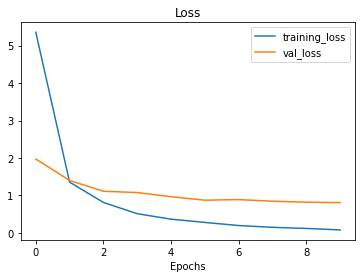

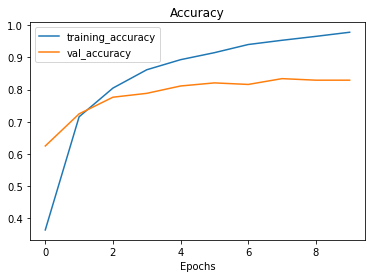

In [ ]:
plot_loss_curves(history)

### RESNET50

#### Modèle sélectionné

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

In [ ]:
train_data_generator = train_datagen.flow_from_directory(
                                                          path_train,
                                                          target_size=(width, height),
                                                          classes = main_breeds_list,
                                                          batch_size =32,
                                                          class_mode='categorical'
                                                          )
test_data_generator = test_datagen.flow_from_directory(
                                                        path_test,
                                                        target_size=(width, height),
                                                        classes=main_breeds_list,
                                                        batch_size=32,
                                                        class_mode='categorical'
                                                       )

Found 3387 images belonging to 20 classes.
Found 857 images belonging to 20 classes.


In [ ]:
resnet_50 = resnet50.ResNet50(include_top=False, weights='imagenet')
#we only train classifier
resnet_50.trainable=False

In [ ]:
inputs = Input(shape=(width,height,3))

In [ ]:
x = resnet_50(inputs)
x = GlobalAveragePooling2D()(x)

In [ ]:
outputs = Dense(nbreeds, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                40980     
                                                                 
Total params: 23,628,692
Trainable params: 40,980
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
t1 = time.time()
history = model.fit(train_data_generator, 
                    validation_data=test_data_generator, 
                    epochs=10,
                    steps_per_epoch=3387 // 32,
                    validation_steps=857 // 32)

t2 = time.time()

Epoch 1/10
105/105 [==============================] - 37s 270ms/step - loss: 0.9222 - accuracy: 0.7380 - val_loss: 0.3407 - val_accuracy: 0.9038
Epoch 2/10
105/105 [==============================] - 25s 239ms/step - loss: 0.2401 - accuracy: 0.9311 - val_loss: 0.2829 - val_accuracy: 0.8966
Epoch 3/10
105/105 [==============================] - 26s 245ms/step - loss: 0.1568 - accuracy: 0.9574 - val_loss: 0.2535 - val_accuracy: 0.9014
Epoch 4/10
105/105 [==============================] - 26s 248ms/step - loss: 0.1082 - accuracy: 0.9759 - val_loss: 0.2702 - val_accuracy: 0.8990
Epoch 5/10
105/105 [==============================] - 25s 241ms/step - loss: 0.0752 - accuracy: 0.9836 - val_loss: 0.2512 - val_accuracy: 0.9111
Epoch 6/10
105/105 [==============================] - 26s 245ms/step - loss: 0.0581 - accuracy: 0.9923 - val_loss: 0.2396 - val_accuracy: 0.9183
Epoch 7/10
105/105 [==============================] - 26s 243ms/step - loss: 0.0449 - accuracy: 0.9943 - val_loss: 0.2363 - val_ac

In [ ]:
print('time : {} min'.format(np.round((t2-t1)/60))) 

time : 5.0 min


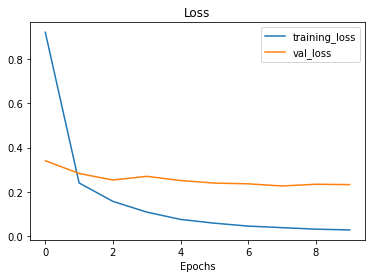

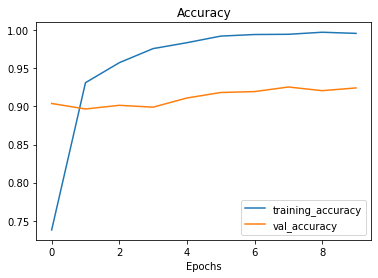

In [ ]:
plot_loss_curves(history)

Nous conservons ce modèle qui nous donne de très bons résultats.

In [ ]:
model.save('/content/drive/MyDrive/projet6/my_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


####Autres essais

En changeant les batch size

In [ ]:
train_data_generator = train_datagen.flow_from_directory(
                                                          path_train,
                                                          target_size=(width, height),
                                                          classes = main_breeds_list,
                                                          batch_size = 256,
                                                          class_mode='categorical'
                                                          )
test_data_generator = test_datagen.flow_from_directory(
                                                        path_test,
                                                        target_size=(width, height),
                                                        classes=main_breeds_list,
                                                        batch_size=256,
                                                        class_mode='categorical'
                                                       )


Found 3387 images belonging to 20 classes.
Found 857 images belonging to 20 classes.


In [ ]:
resnet_50 = resnet50.ResNet50(include_top=False, weights='imagenet')
#we only train classifier
resnet_50.trainable=False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
inputs = Input(shape=(width,height,3))

In [ ]:
x = resnet_50(inputs)
x = GlobalAveragePooling2D()(x)

In [ ]:
outputs = Dense(nbreeds, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
t1 = time.time()
history = model.fit(train_data_generator, 
                    validation_data=test_data_generator, 
                    epochs=20,
                    steps_per_epoch=3387 // 256,
                    validation_steps=857 // 256)

t2 = time.time()

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
13/13 [==============================] - 73s 5s/step - loss: 3.0684 - accuracy: 0.0581 - val_loss: 3.0349 - val_accuracy: 0.0742
Epoch 2/20
13/13 [==============================] - 51s 4s/step - loss: 3.0158 - accuracy: 0.0655 - val_loss: 2.9876 - val_accuracy: 0.0716
Epoch 3/20
13/13 [==============================] - 49s 4s/step - loss: 2.9885 - accuracy: 0.0693 - val_loss: 2.9738 - val_accuracy: 0.0833
Epoch 4/20
13/13 [==============================] - 54s 4s/step - loss: 2.9732 - accuracy: 0.0715 - val_loss: 2.9550 - val_accuracy: 0.0924
Epoch 5/20
13/13 [==============================] - 54s 4s/step - loss: 2.9664 - accuracy: 0.0770 - val_loss: 2.9423 - val_accuracy: 0.1068
Epoch 6/20
13/13 [==============================] - 49s 4s/step - loss: 2.9584 - accuracy: 0.0789 - val_loss: 2.9428 - val_accuracy: 0.0898
Epoch 7/20
13/13 [==============================] - 50s 4s/step - loss: 2.9578 - accuracy: 0.0821 - val_loss: 2.9320 - val_accuracy: 0.1029
Epoch 8/20
13/13 [==

In [ ]:
print('time : {} min'.format(np.round((t2-t1)/60))) 

time : 21.0 min


Changement batch size et learning rate

In [ ]:
train_data_generator = train_datagen.flow_from_directory(
                                                          path_train,
                                                          target_size=(width, height),
                                                          classes = main_breeds_list,
                                                          batch_size =64,
                                                          class_mode='categorical'
                                                          )
test_data_generator = test_datagen.flow_from_directory(
                                                        path_test,
                                                        target_size=(width, height),
                                                        classes=main_breeds_list,
                                                        batch_size=64,
                                                        class_mode='categorical'
                                                       )


Found 3387 images belonging to 20 classes.
Found 857 images belonging to 20 classes.


In [ ]:
resnet_50 = resnet50.ResNet50(include_top=False, weights='imagenet')

In [ ]:
resnet_50.trainable=False

In [ ]:
inputs = Input(shape=(width,height,3))

In [ ]:
x = resnet_50(inputs)
x = GlobalAveragePooling2D()(x)

In [ ]:
outputs = Dense(nbreeds, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
t1 = time.time()
history = model.fit(train_data_generator, 
                    validation_data=test_data_generator, 
                    epochs=20,
                    steps_per_epoch=3387 // 64,
                    validation_steps=857 // 64)

t2 = time.time()

Epoch 1/20
52/52 [==============================] - 40s 533ms/step - loss: 2.8294 - accuracy: 0.1766 - val_loss: 2.3014 - val_accuracy: 0.2885
Epoch 2/20
52/52 [==============================] - 26s 504ms/step - loss: 1.8627 - accuracy: 0.4806 - val_loss: 1.5754 - val_accuracy: 0.5649
Epoch 3/20
52/52 [==============================] - 24s 461ms/step - loss: 1.2950 - accuracy: 0.6937 - val_loss: 1.1705 - val_accuracy: 0.7043
Epoch 4/20
52/52 [==============================] - 23s 442ms/step - loss: 0.9694 - accuracy: 0.7915 - val_loss: 0.9113 - val_accuracy: 0.7812
Epoch 5/20
52/52 [==============================] - 23s 445ms/step - loss: 0.7620 - accuracy: 0.8402 - val_loss: 0.7629 - val_accuracy: 0.8209
Epoch 6/20
52/52 [==============================] - 23s 438ms/step - loss: 0.6282 - accuracy: 0.8670 - val_loss: 0.6545 - val_accuracy: 0.8450
Epoch 7/20
52/52 [==============================] - 23s 441ms/step - loss: 0.5395 - accuracy: 0.8862 - val_loss: 0.5939 - val_accuracy: 0.8534

In [ ]:
print('time : {} min'.format(np.round((t2-t1)/60))) 

time : 12.0 min


En entrainant les dernières couches

In [ ]:
train_data_generator = train_datagen.flow_from_directory(
                                                          path_train,
                                                          target_size=(width, height),
                                                          classes = main_breeds_list,
                                                          batch_size = 32,
                                                          class_mode='categorical'
                                                          )
test_data_generator = test_datagen.flow_from_directory(
                                                        path_test,
                                                        target_size=(width, height),
                                                        classes=main_breeds_list,
                                                        batch_size=32,
                                                        class_mode='categorical'
                                                       )

Found 3387 images belonging to 20 classes.
Found 857 images belonging to 20 classes.


In [ ]:
resnet_50 = resnet50.ResNet50(include_top=False, weights='imagenet')

In [ ]:
len(resnet_50.layers)

175

In [ ]:
for layer in resnet_50.layers[:150]:
   layer.trainable = False

In [ ]:
inputs = Input(shape=(width,height,3))

In [ ]:
x = resnet_50(inputs)
x = GlobalAveragePooling2D()(x)

In [ ]:
outputs = Dense(nbreeds, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
t1 = time.time()
history = model.fit(train_data_generator, 
                    validation_data=test_data_generator, 
                    epochs=10,
                    steps_per_epoch=3387 // 32,
                    validation_steps=857 // 32)

t2 = time.time()

Epoch 1/10
105/105 [==============================] - 35s 286ms/step - loss: 0.8987 - accuracy: 0.7434 - val_loss: 0.3869 - val_accuracy: 0.8798
Epoch 2/10
105/105 [==============================] - 28s 263ms/step - loss: 0.1251 - accuracy: 0.9696 - val_loss: 0.3507 - val_accuracy: 0.8882
Epoch 3/10
105/105 [==============================] - 25s 235ms/step - loss: 0.0354 - accuracy: 0.9964 - val_loss: 0.3250 - val_accuracy: 0.9062
Epoch 4/10
105/105 [==============================] - 26s 245ms/step - loss: 0.0175 - accuracy: 0.9985 - val_loss: 0.3091 - val_accuracy: 0.9038
Epoch 5/10
105/105 [==============================] - 25s 236ms/step - loss: 0.0095 - accuracy: 0.9991 - val_loss: 0.3034 - val_accuracy: 0.9075
Epoch 6/10
105/105 [==============================] - 25s 235ms/step - loss: 0.0080 - accuracy: 0.9991 - val_loss: 0.3284 - val_accuracy: 0.9147
Epoch 7/10
105/105 [==============================] - 25s 234ms/step - loss: 0.0059 - accuracy: 0.9985 - val_loss: 0.3118 - val_ac

In [ ]:
print('time : {} min'.format(np.round((t2-t1)/60))) 

time : 6.0 min


Avec Data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode="reflect",
        preprocessing_function=resnet50.preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

In [ ]:
train_data_generator = train_datagen.flow_from_directory(
                                                          path_train,
                                                          target_size=(width, height),
                                                          classes = main_breeds_list,
                                                          batch_size = 32,
                                                          class_mode='categorical'
                                                          )
test_data_generator = test_datagen.flow_from_directory(
                                                        path_test,
                                                        target_size=(width, height),
                                                        classes=main_breeds_list,
                                                        batch_size= 32,
                                                        class_mode='categorical'
                                                       )

Found 3387 images belonging to 20 classes.
Found 857 images belonging to 20 classes.


In [ ]:
resnet_50 = resnet50.ResNet50(include_top=False, weights='imagenet')

In [ ]:
resnet_50.trainable=False

In [ ]:
inputs = Input(shape=(width,height,3))

In [ ]:
x = resnet_50(inputs)
x = GlobalAveragePooling2D()(x)

In [ ]:
outputs = Dense(nbreeds, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
t1 = time.time()
history = model.fit(train_data_generator, 
                    validation_data=test_data_generator, 
                    epochs=15,
                    steps_per_epoch=3387 // 32,
                    validation_steps=857 // 32)

t2 = time.time()

Epoch 1/15
105/105 [==============================] - 57s 516ms/step - loss: 1.0959 - accuracy: 0.6858 - val_loss: 0.3625 - val_accuracy: 0.8762
Epoch 2/15
105/105 [==============================] - 54s 513ms/step - loss: 0.3721 - accuracy: 0.8876 - val_loss: 0.2925 - val_accuracy: 0.8918
Epoch 3/15
105/105 [==============================] - 53s 505ms/step - loss: 0.2687 - accuracy: 0.9148 - val_loss: 0.2614 - val_accuracy: 0.8978
Epoch 4/15
105/105 [==============================] - 53s 505ms/step - loss: 0.2211 - accuracy: 0.9294 - val_loss: 0.2534 - val_accuracy: 0.9111
Epoch 5/15
105/105 [==============================] - 53s 506ms/step - loss: 0.1904 - accuracy: 0.9341 - val_loss: 0.2645 - val_accuracy: 0.9087
Epoch 6/15
105/105 [==============================] - 54s 512ms/step - loss: 0.1509 - accuracy: 0.9583 - val_loss: 0.2537 - val_accuracy: 0.9075
Epoch 7/15
105/105 [==============================] - 53s 507ms/step - loss: 0.1627 - accuracy: 0.9463 - val_loss: 0.2695 - val_ac

In [ ]:
print('time : {} min'.format(np.round((t2-t1)/60))) 

time : 19.0 min
